## Agenda
        
        0.0 Data Preparation
            0.1 Feature Encoding
        1.0 Baseline model
            1.1 Imbalanced data
                1.1.1. SMOTE
            1.2 (basic) Feature Selection
        2.0 Best Case Scenario of Using the model
            2.1 Good and Worst Case Scenarios of Using the model

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Utils
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.metrics import classification_report

import pickle

In [2]:
raw_data = pd.read_pickle("churn_data_Modeling.pkl")
raw_data.sample()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,annual_revenue,revenue_per_product,total_revenue,age_stage,credit_score_category
515,793,Spain,Male,38,9,0.0,2,1,0,88225.02,0,1102.81275,551.406375,9925.31475,"(32, 39]","(750.0, 800.0]"


## 0.0 Data Preparation

In [3]:
data = raw_data.copy()

### 0.1 Feature Encoding

We have to encode these columns: geography	gender	age_stage	credit_score_category

In [4]:
data = pd.get_dummies( data, prefix=['geography'], columns=['geography'] )

In [5]:
data = pd.get_dummies( data, prefix=['gender'], columns=['gender'] )

In [6]:
data["age_stage"] = data["age_stage"].cat.codes
data["credit_score_category"] = data["credit_score_category"].cat.codes

In [7]:
data.sample()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,annual_revenue,revenue_per_product,total_revenue,age_stage,credit_score_category,geography_France,geography_Germany,geography_Spain,gender_Female,gender_Male
67,735,43,10,123180.01,2,1,1,196673.28,0,3277.888,1638.944,32778.88,3,7,0,1,0,0,1


## 1.0 Baseline model

**We want to be able to figure out accurately  which customer is going to churn. Therefore, recall is the metric that best fits this problem.**

> From those who were churned customers, how many did the model detect?

And as you can see, our model is pretty good identifying not churned customers. That is not what we are interested, though.
Let's see what's happening.

In [8]:
df = data.copy()

In [9]:
X = df.drop(columns=['exited'])
y = df['exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

random_forest_model = RandomForestClassifier(random_state=0)
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

First Random Forest: 

            recall  
       0     0.96
       1     0.48

In [10]:
y_pred = random_forest_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2219
           1       0.76      0.48      0.58       602

    accuracy                           0.86      2821
   macro avg       0.81      0.72      0.75      2821
weighted avg       0.85      0.86      0.84      2821



First, let's try out other algorithms...
    
    Much worse

In [11]:
logistic_model = LogisticRegression(random_state=0)
logistic_model.fit(X_train, y_train)

y_pred = logistic_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.98      0.88      2219
           1       0.46      0.06      0.11       602

    accuracy                           0.78      2821
   macro avg       0.63      0.52      0.50      2821
weighted avg       0.72      0.78      0.71      2821



    GradientBoostingClassifier was as bad as Random Forest.
    For this first cycle, let's Focus on random forest then.

In [12]:
gradient_boost_model = GradientBoostingClassifier(random_state=0).fit(X_train, y_train)

y_pred = gradient_boost_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2219
           1       0.76      0.47      0.58       602

    accuracy                           0.86      2821
   macro avg       0.81      0.71      0.75      2821
weighted avg       0.85      0.86      0.84      2821



### 1.1 Imbalanced data
[Imbalance on data](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/). Let's solve that.

Too many not churned data, that's why the model is so good detecting them.

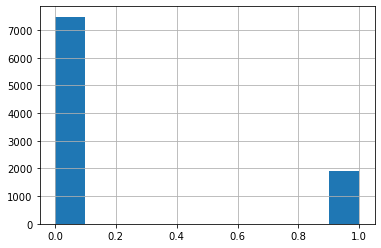

In [13]:
y.hist();

#### 1.1.1. SMOTE

[SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/).

And in this case, instead of undersampling, we're going to oversample.

<img src="imbalanced_data.png">

In [14]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 7479, 0: 7479})


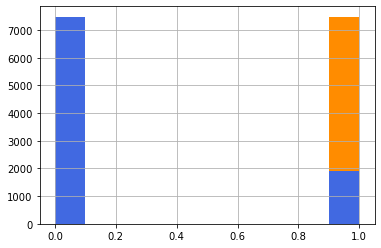

In [15]:
y_res.hist(color='darkorange')
y.hist(color='royalblue');

In [16]:
# EUREKA
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      2234
           1       0.92      0.88      0.90      2254

    accuracy                           0.90      4488
   macro avg       0.90      0.90      0.90      4488
weighted avg       0.90      0.90      0.90      4488



### 1.2 (basic) Feature Selection 

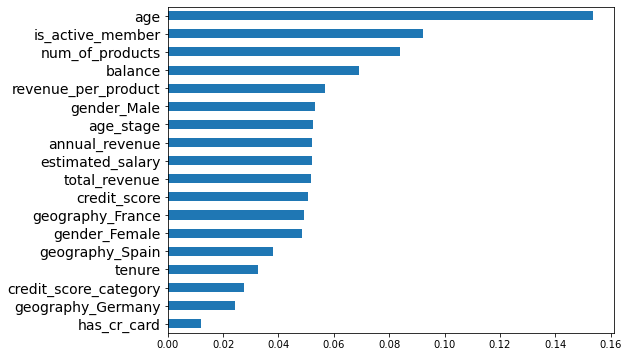

In [17]:
plt.figure(figsize=(8,6))
plt.yticks(size=14)
pd.Series( model.feature_importances_, index = X_test.columns ).sort_values().plot(kind='barh');

In [18]:
new_X_res = X_res.drop(columns= ['has_cr_card', 'tenure','credit_score_category', 'age_stage','total_revenue'])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(new_X_res, y_res, test_size=0.3, random_state=42)

model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      2234
           1       0.92      0.88      0.90      2254

    accuracy                           0.90      4488
   macro avg       0.90      0.90      0.90      4488
weighted avg       0.90      0.90      0.90      4488



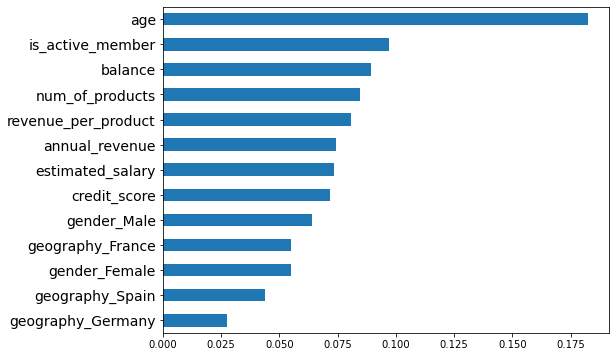

In [20]:
plt.figure(figsize=(8,6))
plt.yticks(size=14)
pd.Series( model.feature_importances_, index = X_test.columns ).sort_values().plot(kind='barh');

For fun!

In [21]:
customer_sample = X_test.sample()
prediction_proba = model.predict_proba(customer_sample)[0][1]
prediction = model.predict(customer_sample)[0]

print(f"Probability of churn: {prediction_proba}")
print(f"Will there be Churn? {prediction}")
print()

real_status = y_test[customer_sample.index[0]]
print(f"Actual Churned Customer? {real_status}")

Probability of churn: 0.85
Will there be Churn? 1

Actual Churned Customer? 1


## 2.0 Best Case Scenario of Using the model
**Return, in terms of revenue, if TopBank uses the model (considering that TopBank could prevent a customer churn if It knew the customer would churn).**

In [22]:
total_customers = 10000
expected_revenue_per_customer = data.annual_revenue.mean()
churned_customers = 2000
model_assertivity = 0.88

expected_revenue_return = (churned_customers *  expected_revenue_per_customer) * model_assertivity
print(f" Expected revenue return {round( expected_revenue_return, 2)}")

 Expected revenue return 2918474.51


### 2.1 Good and Worst Case Scenarios of Using the model

Let's say topBank can't prevent customers who are about to leave from leaving... how can we calculate the revenue for this case?

We'll use the probability of churn. If the probability of a customer leave the company is too high, then we'll consider that a churned customer already. However, actually, for us, it will be considered as a not churned customer, so the model will not detect it, leading the company to not knowing there will be churn from that person. And if TopBank doesn't know, it can't change the customer behavior. Testing some thresholds, these are the results:

        threshold of
            80%  -  churns detected = 621
                    revenue return  = 847,188.15

            70%  -  churns detected = 378
                    revenue return  = 515,679.74

            65%  -  churns detected = 282
                    revenue return  = 384,713.46

            60%  -  churns detected = 178
                    revenue return  = 242,833.32        

In [32]:
predictions         = model.predict(X_test)
predictions_proba   = model.predict_proba(X_test)[:, 1]

# Convert to pandas Series
churn_predictions   = pd.Series( predictions, name='churn_prediction' )
churn_probabilities = pd.Series( predictions_proba, name='churn_proability' )

In [80]:
model_results = pd.concat([churn_predictions, churn_probabilities], axis=1)
threshold_value = .51 # We can prevent them from leaving if their churn probability is is up to... threshold_value

# Changing the predictions based on probability of churn and threshold_value
reformatted_predictions = model_results['churn_proability'].apply(lambda x: 1 if x > 0.5 and x <= threshold_value else 0)
reformatted_predictions = pd.Series( reformatted_predictions, name='adapted_prediction' )

adapted_model_results = pd.concat([model_results, reformatted_predictions], axis=1)

In [81]:
adapted_model_results.sum()

churn_prediction      2154.00
churn_proability      2253.19
adapted_prediction      18.00
dtype: float64

In [82]:
# These are the 88% we detect. How many is 100%?
sum_of_predicted_exit = adapted_model_results.sum()[0]
# math - rule of three 
actual_exited = sum_of_predicted_exit * 1 / 0.88
# Detected based on the new threshold, so we can calculate the new recall
adapted_detections = adapted_model_results.sum()[2]

In [83]:
# From those who were churned customers, how many did the model detect?
sum_of_predicted_exit / actual_exited # Actual Model Assertivity

0.8800000000000001

In [84]:
# From those who were churned customers, how many did the model detect?
adapted_detections / actual_exited  # Model Assertivity based on new threshold value for detecting churn

0.007353760445682452

In [85]:
adapted_model_assertivity = adapted_detections / actual_exited
expected_revenue_return = (churned_customers *  expected_revenue_per_customer) * adapted_model_assertivity
print(f" Expected revenue return {round( expected_revenue_return, 2)}")

 Expected revenue return 24388.37


**It seems, there are many customers about to churn and if topBank doesn't do something about that, that enterprise will broke soon.**

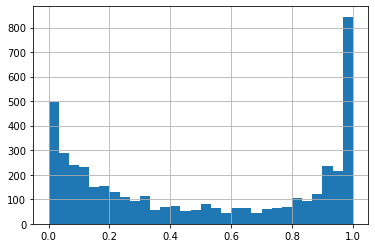

In [31]:
adapted_model_results.churn_proability.hist(bins = 30)

Export the model to use in the application.

In [30]:
with open('topBankModel.pkl','wb') as file:
    pickle.dump(model, file)